In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')


In [2]:
from google.colab import files
uploaded = files.upload()




Saving Autism-Child-Data1.csv to Autism-Child-Data1.csv


In [4]:
import io

df = pd.read_csv(io.BytesIO(uploaded['Autism-Child-Data1.csv']))
print(df.head())

   id  A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0   1         1         1         0         0         1         1         0   
1   2         1         1         0         0         1         1         0   
2   3         1         1         0         0         0         1         1   
3   4         0         1         0         0         1         1         0   
4   5         1         1         1         1         1         1         1   

   A8_Score  A9_Score  ...  gender       ethnicity jundice austim  \
0         1         0  ...       m          Others      no     no   
1         1         0  ...       m  Middle Eastern      no     no   
2         1         0  ...       m               ?      no     no   
3         0         0  ...       f               ?     yes     no   
4         1         1  ...       m          Others     yes     no   

   contry_of_res used_app_before result    age_desc  relation Class/ASD  
0         Jordan              no    

In [5]:
df.shape


(292, 22)

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               292 non-null    int64 
 1   A1_Score         292 non-null    int64 
 2   A2_Score         292 non-null    int64 
 3   A3_Score         292 non-null    int64 
 4   A4_Score         292 non-null    int64 
 5   A5_Score         292 non-null    int64 
 6   A6_Score         292 non-null    int64 
 7   A7_Score         292 non-null    int64 
 8   A8_Score         292 non-null    int64 
 9   A9_Score         292 non-null    int64 
 10  A10_Score        292 non-null    int64 
 11  age              292 non-null    object
 12  gender           292 non-null    object
 13  ethnicity        292 non-null    object
 14  jundice          292 non-null    object
 15  austim           292 non-null    object
 16  contry_of_res    292 non-null    object
 17  used_app_before  292 non-null    ob

In [7]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
id,292.0,146.500000,84.437354,1.0,73.75,146.5,219.25,292.0
A1_Score,292.0,0.633562,0.482658,0.0,0.00,1.0,1.00,1.0
A2_Score,292.0,0.534247,0.499682,0.0,0.00,1.0,1.00,1.0
A3_Score,292.0,0.743151,0.437646,0.0,0.00,1.0,1.00,1.0
A4_Score,292.0,0.551370,0.498208,0.0,0.00,1.0,1.00,1.0
A5_Score,292.0,0.743151,0.437646,0.0,0.00,1.0,1.00,1.0
A6_Score,292.0,0.712329,0.453454,0.0,0.00,1.0,1.00,1.0
A7_Score,292.0,0.606164,0.489438,0.0,0.00,1.0,1.00,1.0
A8_Score,292.0,0.496575,0.500847,0.0,0.00,0.0,1.00,1.0
A9_Score,292.0,0.493151,0.500811,0.0,0.00,0.0,1.00,1.0


In [8]:
df['ethnicity'].value_counts()


White-European    108
Asian              46
?                  43
Middle Eastern     27
South Asian        21
Others             14
Black              14
Latino              8
Hispanic            7
Pasifika            2
Turkish             2
Name: ethnicity, dtype: int64

In [ ]:
df['relation'].value_counts()


Parent                      214
?                            43
Relative                     17
Health care professional     13
Self                          4
self                          1
Name: relation, dtype: int64

In [9]:
df = df.replace({'yes':1, 'no':0, '?':'Others', 'others':'Others'})


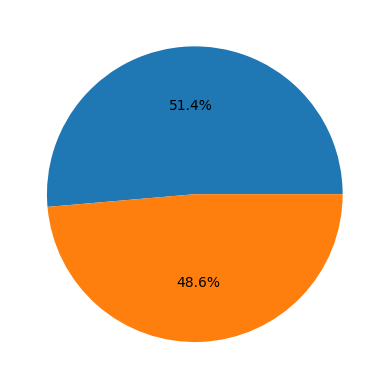

In [10]:
plt.pie(df['Class/ASD'].value_counts().values, autopct='%1.1f%%')
plt.show()


In [14]:
ints = []
objects = []

for col in df.columns:
  if df[col].dtype == int:
    ints.append(col)
  elif df[col].dtype == object:
    objects.append(col)




In [15]:
ints.remove('id')
ints.remove('Class/ASD')


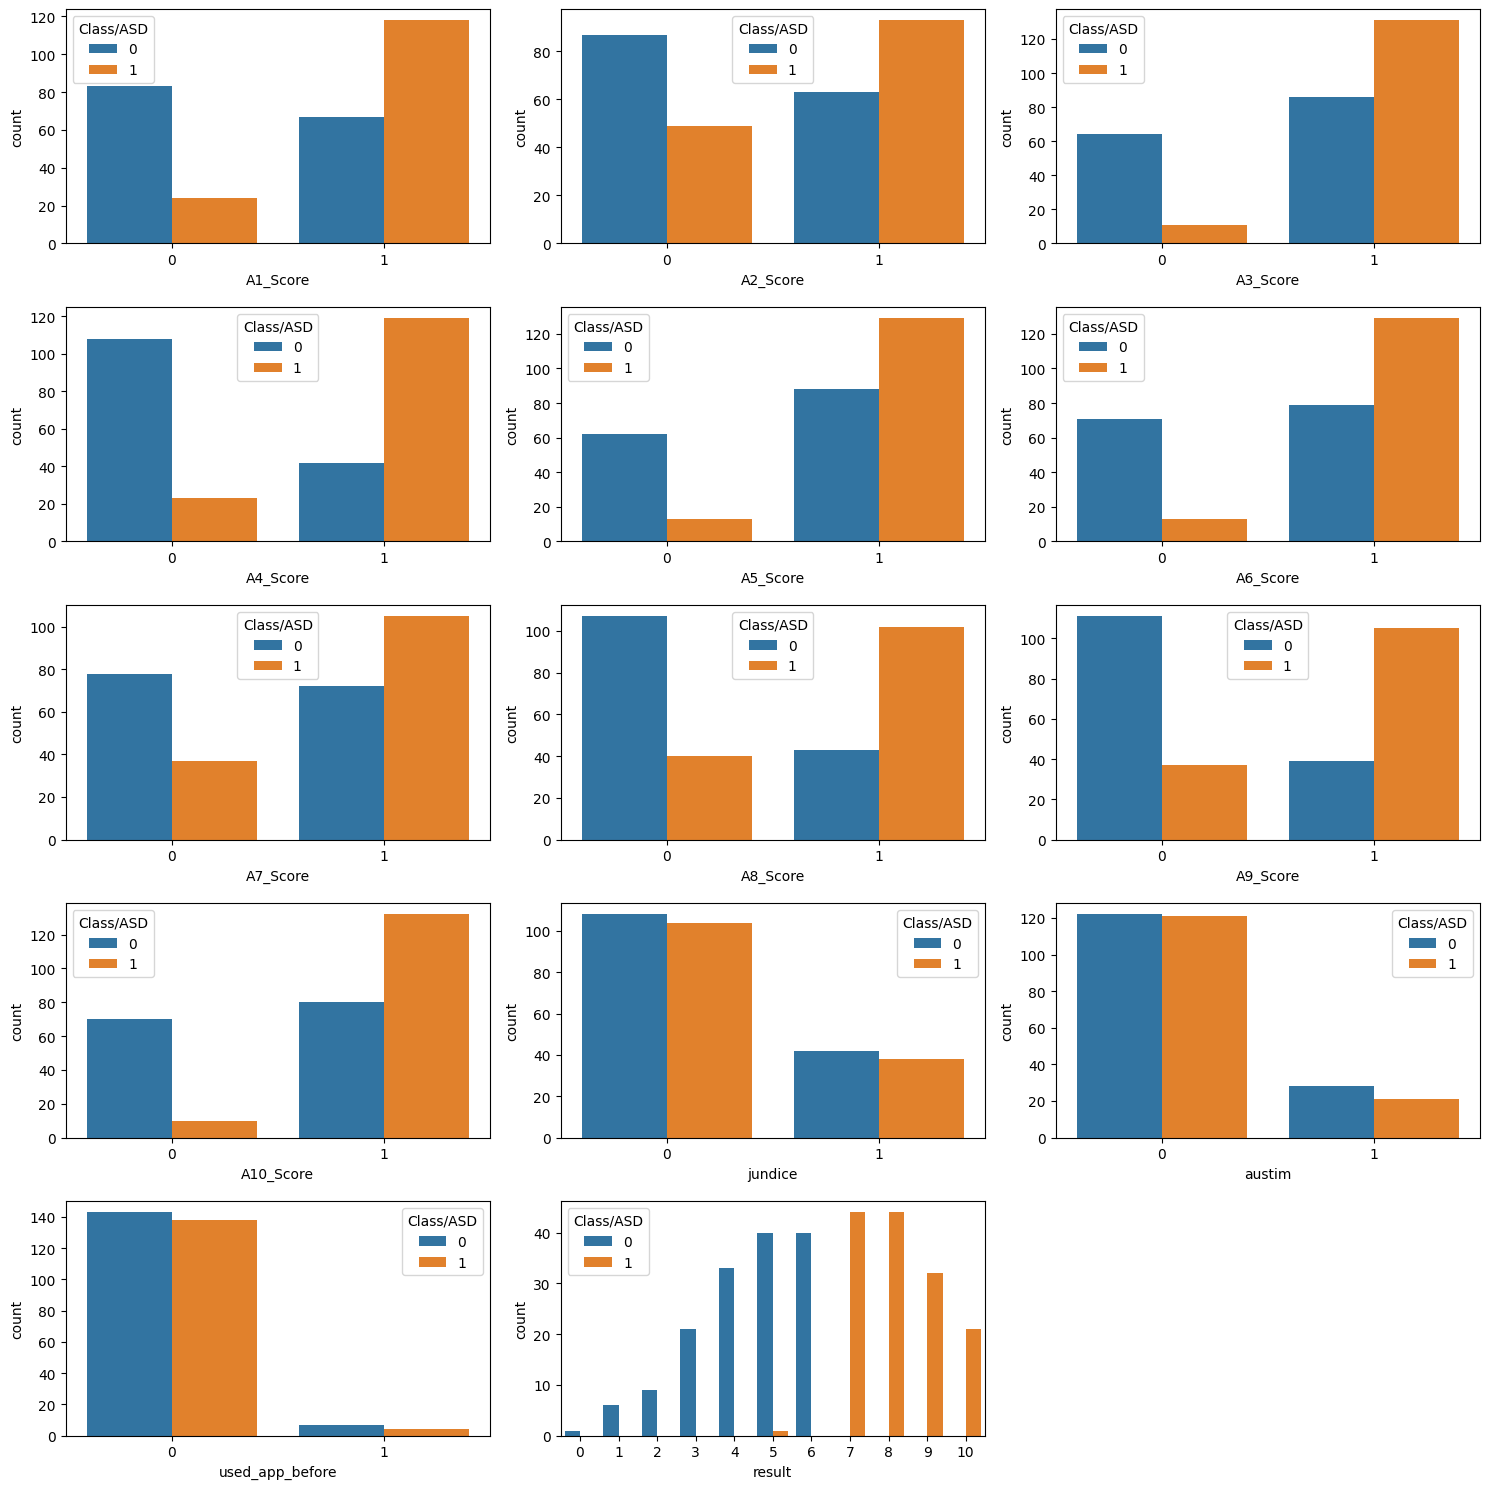

In [16]:
plt.subplots(figsize=(15,15))

for i, col in enumerate(ints):
  plt.subplot(5,3,i+1)
  sb.countplot(df, x=df[col], hue=df['Class/ASD'])
plt.tight_layout()
plt.show()


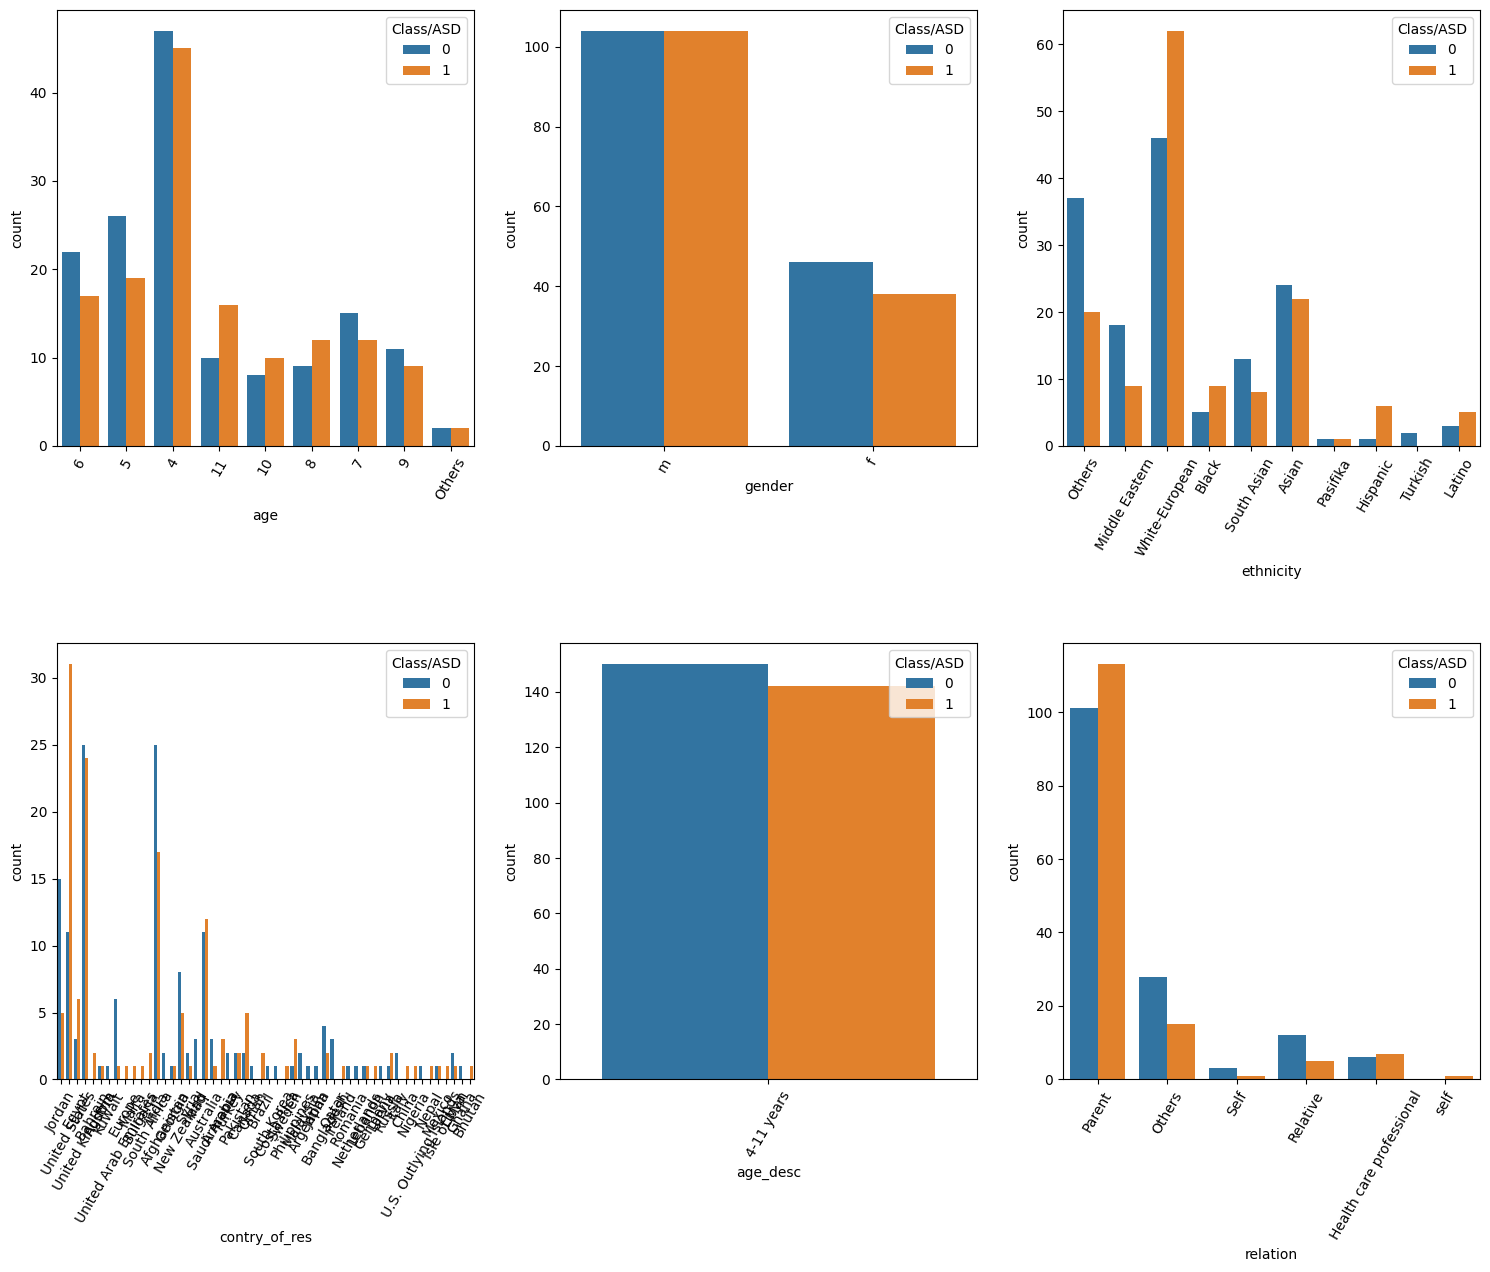

In [17]:
plt.subplots(figsize=(15, 30))

for i, col in enumerate(objects):
	plt.subplot(5, 3, i+1)
	sb.countplot(df, x=df[col], hue=df['Class/ASD'])
	plt.xticks(rotation=60)
plt.tight_layout()
plt.show()


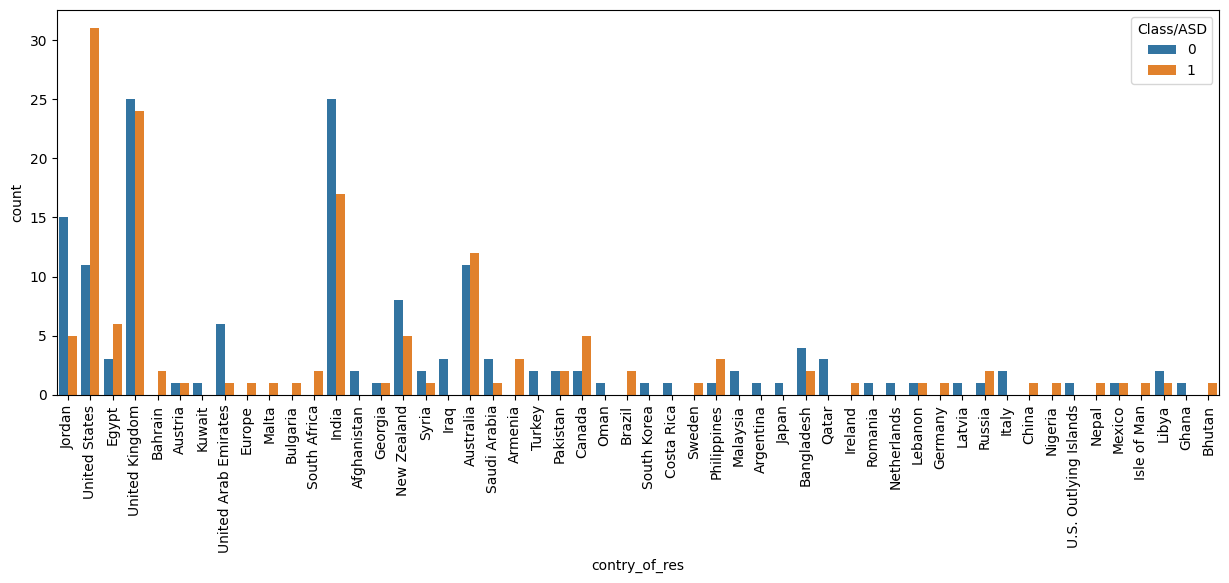

In [18]:
plt.figure(figsize=(15,5))
sb.countplot(data=df, x=df['contry_of_res'], hue=df['Class/ASD'])
plt.xticks(rotation=90)
plt.show()


In [19]:
df = df[df['result']>-5]
df.shape


(292, 22)

In [20]:
# This functions make groups by taking
# the age as a parameter
df['age'] = pd.to_numeric(df['age'], errors='coerce')

def convertAge(age):
	if age < 4:
		return 'Toddler'
	elif age < 12:
		return 'Kid'
	elif age < 18:
		return 'Teenager'
	elif age < 40:
		return 'Young'
	else:
		return 'Senior'

df['ageGroup'] = df['age'].apply(convertAge)


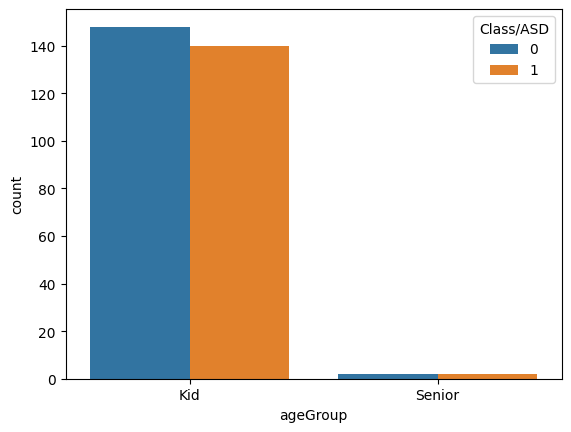

In [21]:
sb.countplot(x=df['ageGroup'], hue=df['Class/ASD'])
plt.show()


In [22]:
def add_feature(data):

# Creating a column with all values zero
  data['sum_score'] = 0
  for col in data.loc[:,'A1_Score':'A10_Score'].columns:

	  # Updating the 'sum_score' value with scores
	  # from A1 to A10
	  data['sum_score'] += data[col]

  # Creating a random data using the below three columns
  data['ind'] = data['austim'] + data['used_app_before'] + data['jundice']

  return data

df = add_feature(df)


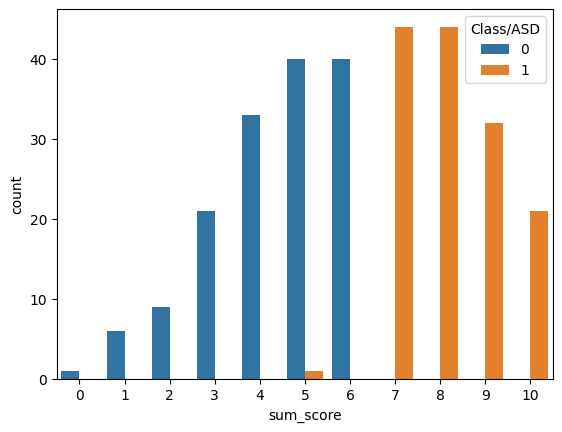

In [23]:
sb.countplot(x=df['sum_score'], hue=df['Class/ASD'])
plt.show()


In [24]:
# Applying log transformations to remove the skewness of the data.
df['age'] = df['age'].apply(lambda x: np.log(x))


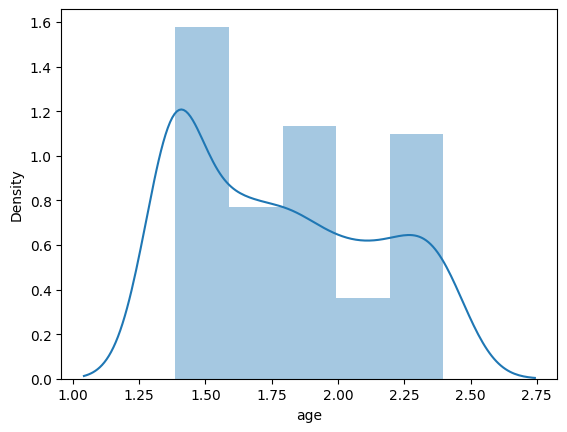

In [25]:
sb.distplot(df['age'])
plt.show()


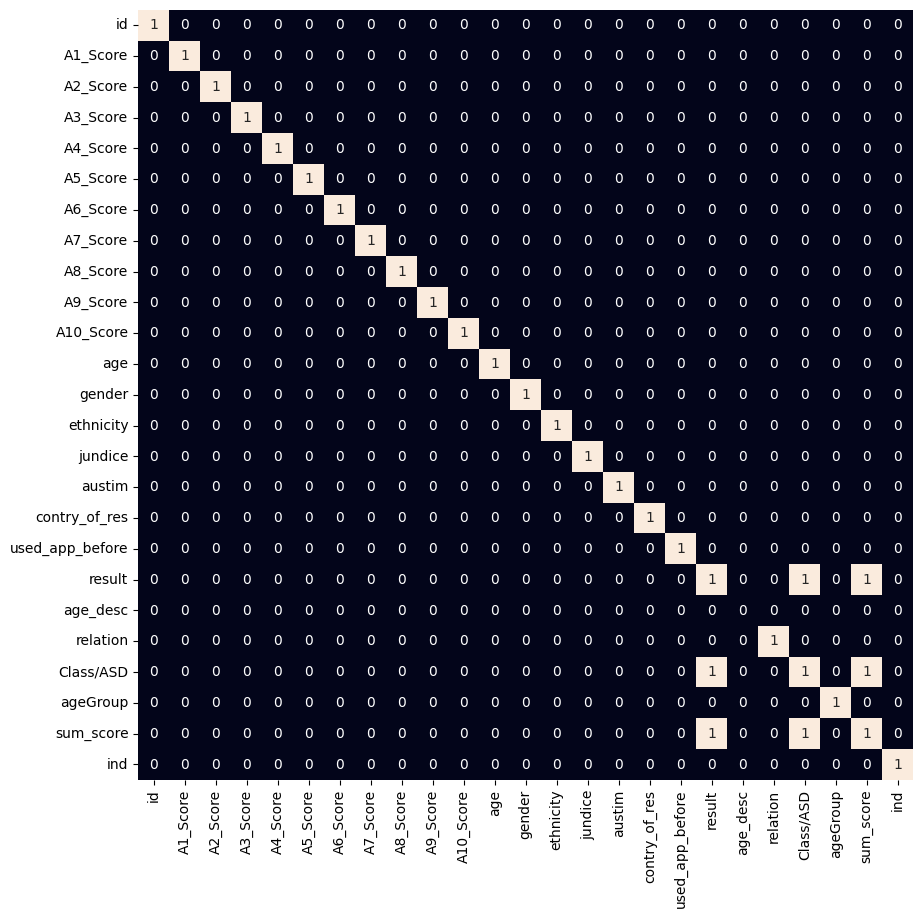

In [26]:
def encode_labels(data):
	for col in data.columns:

	# Here we will check if datatype
	# is object then we will encode it
	  if data[col].dtype == 'object':
		  le = LabelEncoder()
		  data[col] = le.fit_transform(data[col])

	return data

df = encode_labels(df)

# Making a heatmap to visualize the correlation matrix
plt.figure(figsize=(10,10))
sb.heatmap(df.corr() > 0.8, annot=True, cbar=False)
plt.show()


In [27]:
removal = ['id', 'age_desc', 'used_app_before', 'austim']
features = df.drop(removal + ['Class/ASD'], axis=1)
target = df['Class/ASD']


In [28]:
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size = 0.2, random_state=10)

# As the data was highly imbalanced we will balance it by adding repetitive rows of minority class.
ros = RandomOverSampler(sampling_strategy='minority',random_state=0)
X, Y = ros.fit_resample(X_train,Y_train)
X.shape, Y.shape


((246, 20), (246,))

In [29]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)


In [31]:
from sklearn.impute import SimpleImputer

# Create an imputer with the desired strategy (e.g., mean)
imputer = SimpleImputer(strategy='mean')

# Apply imputation to fill missing values in X
X_imputed = imputer.fit_transform(X)
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_imputed, Y, test_size=0.2, random_state=42)
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf')]

# Fit the models using the training data
for model in models:
    model.fit(X_train, Y_train)

    print(f'{model} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, model.predict(X_train)))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_val, model.predict(X_val)))








LogisticRegression() : 
Training Accuracy :  0.995049504950495
Validation Accuracy :  0.9821428571428572
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) : 
Training Accuracy :  0.995049504950495
Validation Accuracy :  1.0
SVC() : 
Training Accuracy :  0.9897863470557582
Validation Accuracy :  0.

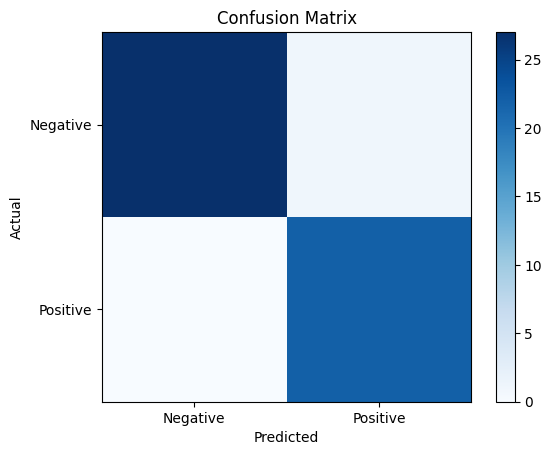

In [32]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
confusion = confusion_matrix(Y_val, models[0].predict(X_val))

# Plot the confusion matrix
plt.imshow(confusion, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.yticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()


